(C) Gerold Baier, University College London, 2025

# Model of Coupled E-I Oscillators with noise


## Import

In [1]:
from matplotlib.pyplot import subplots

from scipy.integrate import solve_ivp
from scipy.signal import find_peaks, butter, sosfilt

from numpy import zeros, ones, tanh, mod, gradient, linspace, sign, log, sort, complex128, pi
from numpy import sqrt, fill_diagonal, ndarray, amax, amin, where, c_, histogram
from numpy import asarray, array, around, arange, corrcoef, flip, var, append, exp 

from numpy.random import uniform, normal, seed, default_rng, randn, rand

from scipy.fft import rfftfreq, rfft, irfft


import sk_dsp_comm.sigsys as ss


## Model and Functions

## The two-variable neural population oscillator

The two populations' temporal dynamics with inhibitory internal coupling is described by two first-order nonlinear differential equations:

$$ \frac{dEx}{dt}      = (h_{ex}      - Ex    - c_2*sigmoid(In) + c_{EE}*\sum_{n=1}^{N} *sigmoid(Ex_n))*\tau_{ex} + pert$$
$$ \frac{dIn}{dt} \,\, = (h_{in} \,\, - In \, - c_4*sigmoid(In) + c_{EI}*\sum_{n=1}^{N} *sigmoid(Ex_n))*\tau_{in} $$

$Ex$ and $In$ are time-dependant variables representing the excitatory and inhibitory neural population, respectively.

$h_{ex}$ and $h_{in}$ are model parameters representing constant (external) input to the excitatory and inhibitory population, respectively.

$c_2$ and $c_4$ are parameters that control the internal inhibition of the two populations.

$c_{EE}$ and $c_{EI}$ are the coupling constants of the excitatory coupling matrices. 

$\tau_{ex}$ and $\tau_{in}$ are the poulation time constants.

_pert_ represents an additive external perturbation.

Function _sigmoid_ is the continuous step function, conmputationally implemented as tangens hyperbolicus.

In [2]:
def sigmoid(u):
    return tanh(u)
    
# With noise array
def N_oscillators_noise(t, y, N, h_ex_rand, h_in_rand, 
                        coupling_matrix_EE, coupling_matrix_EI, coupling_strength_EE, coupling_strength_EI,
                        pars, sr, time_stop, noise):

    tau_ex, tau_in, c2, c4 = pars
    
    noise_index = int(t*sr)
    
    if noise_index >= time_stop*sr:

        dydt = zeros(2*N)
        
        return dydt

    
    # Separate Variables
    y_ex = y[:-1:2]
    y_in = y[1::2]

    dy_ex, dy_in = zeros(N), zeros(N)
    dydt = zeros(2*N)

    for osc in arange(N):
        
        coup_EE = sum(coupling_matrix_EE[:, osc] * y_ex)
        coup_EI = sum(coupling_matrix_EI[:, osc] * y_ex)
            
        dy_ex[osc] = (h_ex_rand[osc] - y_ex[osc] - c2*sigmoid(y_in[osc]) + 
                      coupling_strength_EE*sigmoid(coup_EE) + noise[noise_index, osc])*tau_ex 
        dy_in[osc] = (h_in_rand[osc] - y_in[osc] - c4*sigmoid(y_in[osc]) + 
                      coupling_strength_EI*sigmoid(coup_EI))*tau_in

    # Combine Variables
    dydt[:-1:2] = dy_ex
    dydt[1: :2] = dy_in

    return dydt


In [64]:
def plot_series(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex_', 'In_')

    no_vars = len(name_vars)

    if N == 1:

        fig, ax = subplots(ncols=len(name_vars), figsize=(8, 6))

        for ind in arange(no_vars):

            ax[ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, ind], linewidth=2, c='b')
            ax[ind].set_xticks(linspace(0, (time_end-time_begin)*sr, 5));
            ax[ind].set_xticklabels([]);
            ax[ind].set_xlabel('Time', fontsize=14);
            ax[ind].set_ylabel(name_vars[ind], fontsize=14)
            y_min, y_max = ax[ind].get_ylim()
            ax[ind].set_yticks(linspace(y_min, y_max, 3));
            ax[ind].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);

    else:

        y_max1 = amax(data[:, arange(0, 2*N, 2)])

        if y_max1 > 0:

            y_max1_ax = 1.1*y_max1

        else:

            y_max1_ax = 0.9*y_max1


        y_min1 = amin(data[:, arange(0, 2*N, 2)])

        if y_min1 > 0:

            y_min1_ax = 0.9*y_min1

        else:

            y_min1_ax = 1.1*y_min1


        y_max2 = amax(data[:, arange(1, 2*N+1, 2)])

        if y_mx2 > 0:

            y_max2_ax = 1.1*y_max2

        else:

            y_max2_ax = 0.9*y_max2   


        y_min2 = amin(data[:, arange(1, 2*N+1, 2)])

        if y_min2 > 0:

            y_min2_ax = 0.9*y_min2

        else:

            y_min2_ax = 1.1*y_min2


        fig, ax = subplots(ncols=len(name_vars), nrows=N, figsize=(10, 6))

        for osc in arange(N):
            for ind in arange(2):

                if ind == 0:
                    ax[osc, ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 2*osc+ind], linewidth=1, c='b')
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min1_ax, y_max1_ax)   
                    ax[osc, ind].set_yticks(linspace(y_min1_ax, y_max1_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min1_ax, y_max1_ax, 3),1), fontsize=14);

                elif ind == 1:
                    ax[osc, ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 2*osc+ind], linewidth=1, c='r')
                    
                    ax[osc, ind].set_xticklabels([]);
                    ax[osc, ind].set_ylim(y_min2_ax, y_max2_ax)
                    ax[osc, ind].set_yticks(linspace(y_min2_ax, y_max2_ax, 3));
                    ax[osc, ind].set_yticklabels(around(linspace(y_min2_ax, y_max2_ax, 3),1), fontsize=14);

                if osc == N-1:

                    ax[N-1, ind].set_xlabel('Time', fontsize=14);
                    # print(time[time_begin*sr:time_end*sr].size)
                    # print((time_end-time_begin)*sr)
                    ax[N-1, ind].set_xticks(linspace(time_begin, time_end, 5));
                    ax[N-1, ind].set_xticklabels(linspace(time_begin, time_end, 5));

                label_text = name_vars[ind] + str(osc+1)

                ax[osc, ind].set_ylabel(label_text, fontsize=14)

    fig.tight_layout()
    
    return fig, ax

def generate_multivariate_pink_noise(n_samples, n_series, random_seed=None):
    if random_seed is not None:
        seed(random_seed)

    # Frequencies (half-spectrum)
    freqs = rfftfreq(n_samples)
    freqs[0] = freqs[1]  # Avoid division by zero at DC

    n_freqs = len(freqs)

    # Allocate array for frequency domain data (complex)
    spectrum = zeros((n_freqs, n_series), dtype=complex128)

    # Create scaled random spectra for each series
    for m in range(n_series):
        amplitudes = randn(n_freqs) / sqrt(freqs)
        phases = exp(1j * 2 * pi * rand(n_freqs))
        spectrum[:, m] = amplitudes * phases

    # Inverse FFT to get time-domain pink noise
    pink = irfft(spectrum, n=n_samples, axis=0)

    # Normalize each series to zero mean and unit variance
    pink -= pink.mean(axis=0)
    pink /= pink.std(axis=0)

    return pink  # shape (n_samples, n_series)


## Time Series


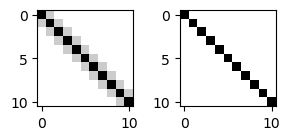

In [70]:
# Number of oscillators
N = 11

# Excitatory input parameter
h_ex_0 = -6.8 # -6.5
h_in_0 = -4.0

eps          = 0.01
RANDOM_STATE = 11111
seed(RANDOM_STATE)
random_vals        = eps*normal(0,1,size=N)
random_vals_sorted = sort(random_vals)
h_ex_rand = h_ex_0 - random_vals_sorted
h_in_rand = h_in_0 - eps*normal(0,1,size=N)

# Parameters

# pars = (1, 1.5, 10, 0) # Slow Homoclinic
pars = (1, 1, 10, 0) # Fast SNIC
# t_ex, t_in, c2, c4


coupling_strength_EE, coupling_strength_EI = 5., 10.

frac_EE, frac_EI = 0.2, 0.
    
coupling_matrix_EE_ini = zeros(shape=(N, N))
coupling_matrix_EI_ini = zeros(shape=(N, N))

fill_diagonal(coupling_matrix_EE_ini[0:-1,1:], frac_EE)
fill_diagonal(coupling_matrix_EI_ini[0:-1,1:], frac_EI)

coupling_matrix_EE = coupling_matrix_EE_ini.T + coupling_matrix_EE_ini
coupling_matrix_EI = coupling_matrix_EI_ini.T + coupling_matrix_EI_ini

fill_diagonal(coupling_matrix_EE, 1)
fill_diagonal(coupling_matrix_EI, 1)

# Pick Initial conditions:
# y_ini = normal(size=2*N)
y_ini = y[-1, :]

# Time array
time_stop = 50
t_span    = (0, time_stop)
sr        = 1000
samples   = time_stop*sr
time      = linspace(start=0, stop=time_stop, num=samples)

fig, ax = subplots(ncols=2, figsize=(3, 3))

ax[0].imshow(coupling_matrix_EE, cmap='gray_r');
ax[1].imshow(coupling_matrix_EI, cmap='gray_r');

fig.tight_layout()

In [71]:
pink_multivar = generate_multivariate_pink_noise(samples, N, random_seed=42)

order, band_low, band_high = 5, 1, 20

sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

random_data_filtered = zeros((samples, N))

for index, column in enumerate(pink_multivar.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    random_data_filtered[:, index] = backwards[-1::-1]

random_strength = 5

noise = random_strength * random_data_filtered

noise.shape

(50000, 11)

In [72]:
# solution = solve_ivp(model, (0, 30), (100, 3), max_step=0.01)

solution = solve_ivp(fun=N_oscillators_noise, t_span=t_span, y0=y_ini, t_eval=time,
              args=(N, h_ex_rand, h_in_rand, 
                    coupling_matrix_EE,   coupling_matrix_EI, 
                    coupling_strength_EE, coupling_strength_EI, 
                    pars, sr, time_stop, noise), max_step=0.1)

t = solution.t
y = solution.y.T

y_unfiltered = y[:,1::2] - y[:,::2]

print('End of run:', y_unfiltered.shape)
print('')


End of run: (50000, 11)



## Plot Time Series

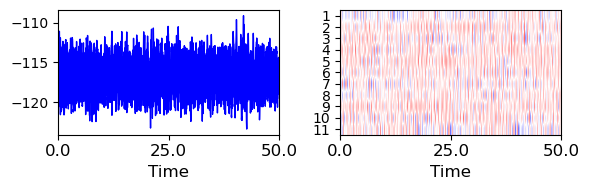

In [87]:
start, stop = 0, y_unfiltered.shape[0]

offset = 0

vmin, vmax = -110., -100.

###################################################
fig, ax = subplots(nrows=1, ncols=2, figsize=(6, 2))

ax[0].plot(10*y_unfiltered[start:stop, :] + offset*arange(N-1,-1,-1), 
        linewidth=1, color='b');
# ax[0].set_yticks(offset*arange(N))
# ax[0].set_yticklabels(flip(arange(N))+1)
ax[0].margins(x=0)
ax[0].set_xticks(linspace(0, stop-start, 3))
labl = linspace(start/sr, stop/sr, 3)
ax[0].set_xticklabels(labl, fontsize=12)
ax[0].set_xlabel('Time', fontsize=12)


ax[1].imshow(y_unfiltered[start:stop, :].T, aspect='auto', 
          cmap='bwr_r'
            # , vmin=vmin, vmax=vmax
              );
ax[1].set_xticks(linspace(0, stop-start, 3))
labl = linspace(start/sr, stop/sr, 3)
ax[1].set_xticklabels(labl, fontsize=12)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_yticks(arange(y_unfiltered.shape[1]));
ax[1].set_yticklabels(arange(y_unfiltered.shape[1])+1);

fig.tight_layout()


## Bipolar Montage

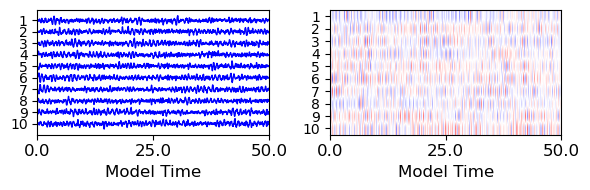

In [88]:
if N==2:
    
    no_diffs = 1

    y_all_diffs = zeros(y.shape[0])

    y_all_diffs = y[:, 2] - y[:, 0]

        
    fig, ax = subplots(nrows=2, figsize=(8, 4))

    # legend_label = 'Diff ' + str(1)
    ax[0].plot(time, y_all_diffs, linewidth=2, c='b')
    ax[0].set_xticklabels([])

    ax[1].imshow(y_all_diffs.reshape(-1, 1).T, aspect='auto', interpolation='None', cmap='bwr', vmin=-2, vmax=2);

    fig.tight_layout()

elif N>2:
    
    no_nearest_diffs = N-1

    y_nearest_diffs = zeros((y_unfiltered.shape[0], no_nearest_diffs))
        
    for index2, series in enumerate(y_unfiltered[:, :no_nearest_diffs].T):

        y_nearest_diffs[:, index2] = y_unfiltered[:, index2+1] - y_unfiltered[:, index2]



    start, stop = 0, y_nearest_diffs.shape[0]

    offset = 2

    vmin, vmax = -1, 1


    fig, ax = subplots(nrows=1, ncols=2, figsize=(6, 2))

    ax[0].plot(y_nearest_diffs[start:stop, :] + offset*arange(N-2,-1,-1), 
            linewidth=1, color='b');
    # ax[1, 0].plot(y_nearest_diffs[start:stop, :, 1] + offset*arange(N-2,-1,-1), 
    #         linewidth=1, color='b');

    ax[0].set_yticks(offset*arange(N-1))
    ax[0].set_yticklabels(flip(arange(N-1))+1)
    # ax[0, 0].set_ylim(-2, 5)
    ax[0].margins(x=0)
    ax[0].set_xticks(linspace(0, stop-start, 3))
    labl = linspace(start/sr, stop/sr, 3)
    ax[0].set_xticklabels(labl, fontsize=12)
    ax[0].set_xlabel('Model Time', fontsize=12)

    ax[1].imshow(y_nearest_diffs[start:stop, :].T, aspect='auto', 
              cmap='bwr', vmin=vmin, vmax=vmax);
    # ax[1, 1].imshow(y_nearest_diffs[start:stop, :, 1].T, aspect='auto', 
    #           cmap='bwr', vmin=vmin, vmax=vmax);

    ax[1].set_xticks(linspace(0, stop-start, 3))
    labl = linspace(start/sr, stop/sr, 3)
    ax[1].set_xticklabels(labl, fontsize=12)
    ax[1].set_xlabel('Model Time', fontsize=12)
    ax[1].set_yticks(arange(y_unfiltered.shape[1]-1));
    ax[1].set_yticklabels(arange(y_unfiltered.shape[1]-1)+1);

fig.tight_layout()

# fig.savefig('Turing_Figs/Fig_3c_StochasticSimulation_with_Perturbation.png', format='png')
